In [1]:
import sys
sys.path.append('/workspaces/bha2/src')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from connectivity_functions import *
from tree_functions import *
from io_functions import load_data
import os
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)
import seaborn as sns


/opt/conda/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [26]:
project_path = "/workspaces/bha2"
conn_size = 964

In [27]:
# check if fcm and scm are stored in tmp folder
if os.path.exists(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy")):
    fcm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"))
    scm = np.load(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"))
    print("fcm and scm loaded from tmp folder")
else:
    sc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "sc"))
    fc_group = load_data(os.path.join(project_path, "data", "raw", "n" + str(conn_size), "fc"))
    fcm, scm = connectome_average(fc_group, sc_group)
    os.mkdir(os.path.join(project_path, "tmp"))
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_fcm.npy"), fcm)
    np.save(os.path.join(project_path, "tmp", "n" + str(conn_size) + "_scm.npy"), scm)


fcm and scm loaded from tmp folder


In [28]:
zero_rows_sc = np.where(~scm.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_sc, fcm, scm)
density = np.where(scm_nonzero.flatten() > 0, 1, 0).sum(dtype=float) / (len(scm_nonzero.flatten()))
fcm_thr = density_threshold(fcm_nonzero, density)
zero_rows_fc = np.where(~fcm_thr.any(axis=1))[0]
fcm_nonzero, scm_nonzero = remove_rois_from_connectomes(zero_rows_fc, fcm_thr, scm_nonzero)
fcm_bin = np.where(abs(fcm_nonzero) > 0, 1, 0)
scm_bin = np.where(scm_nonzero > 0, 1, 0) 

print("connectome density = " + str(density))

connectome density = 0.19200340903221363


Text(0.5, 1.0, 'Structural connectivity matrix')

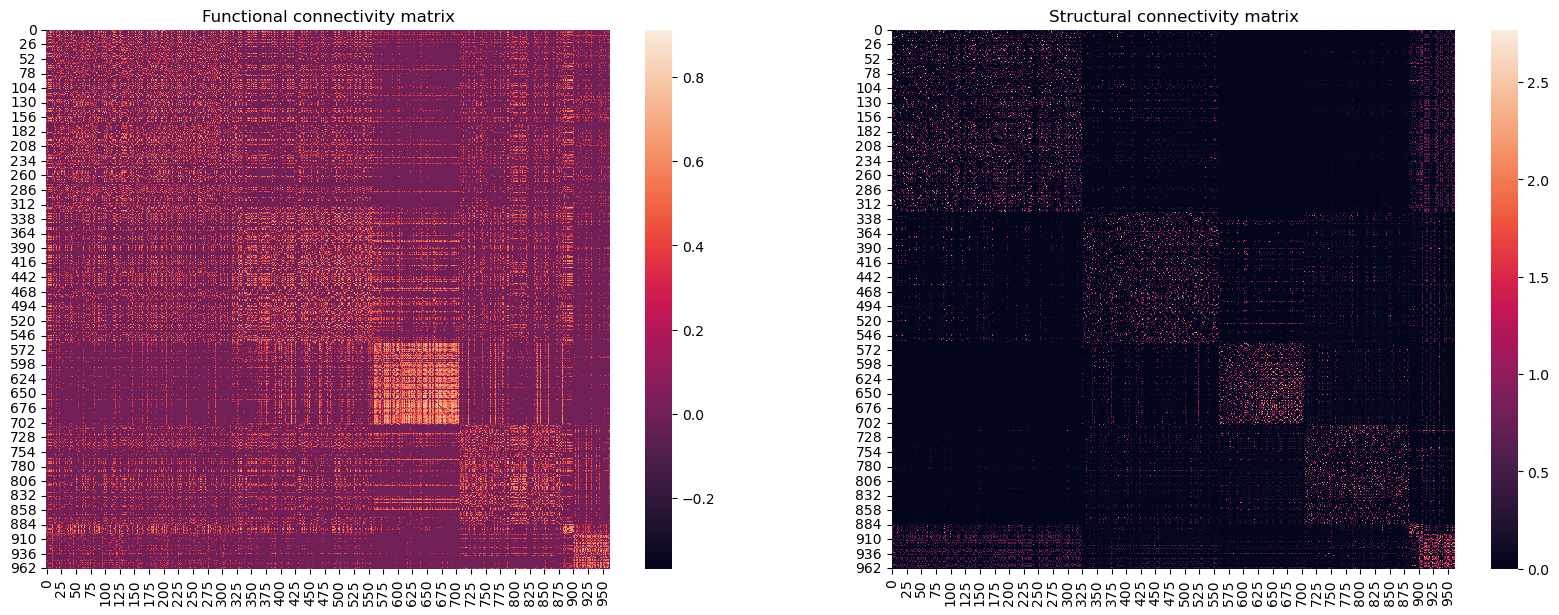

In [29]:
plot, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.heatmap(fcm_nonzero, ax=ax[0])
ax[0].set_title("Functional connectivity matrix")
sns.heatmap(np.log10(scm_nonzero+1), ax=ax[1])
ax[1].set_title("Structural connectivity matrix")

In [30]:
tree_folder = "tree_network_measures"
tree_min = 2
tree_max = 100
#get the rows with all the elements with zero

for g in np.arange(0, 1.1, 0.1):
    W = matrix_fusion(g, fcm_bin, scm_bin)
    t_dict = tree_dictionary(tree_min, tree_max, W, tree_class = "full")
    json.dump(t_dict, open(os.path.join(project_path, "data", "results", "n" + str(conn_size), "tree_equaldensity_bin_full_g_" + str(round(g, 2)) + ".json"), "w"))